### Training

Next, we perform training. We use the train, dev, and test folders specified above, and our logging is done in tensorboard. The model is saved every `save_every` epochs; the model with the best IoU is also saved under the name `model_best`.

In [11]:
from addict import Dict
from pathlib import Path

import albumentations as A
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2

data_dir = Path("glacier_grey_data")
process_dir = data_dir / "processed_planet_scope"

args = Dict({
    "batch_size": 1,
    "run_name": "demo", 
    "epochs": 100,
    "save_every": 50,
    "loss_type": "dice",
    "device": "cuda:0"
})

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

train_transform = A.Compose(
        [
            #A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            #A.Rotate(limit=35, p=1.0),
            #A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
        [

            #A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )


In [12]:
from glacier_mapping.data.data import fetch_loaders
from glacier_mapping.models.frame import Framework
import glacier_mapping.train as tr
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from glacier_mapping.models.metrics import diceloss
import yaml
import torch
import json

In [13]:


conf = Dict(yaml.safe_load(open("conf/train.yaml", "r")))
print(args.batch_size)
loaders = fetch_loaders(process_dir, batch_size=args.batch_size,
                        #train_transform=train_transform, val_transform=val_transforms,
                        )
device = torch.device(args.device)

loss_fn = None
outchannels = conf.model_opts.args.outchannels
if args.loss_type == "dice":
    loss_fn = diceloss(
        act=torch.nn.Softmax(dim=1), 
        w=[0.6, 0.2], # clean ice, debris, background
        outchannels=outchannels, 
        label_smoothing=0.2
    )
    
frame = Framework(
    model_opts=conf.model_opts,
    optimizer_opts=conf.optim_opts,
    reg_opts=conf.reg_opts,
    device=device,
    loss_fn=loss_fn
)

# Setup logging
writer = SummaryWriter(f"{data_dir}/{args.run_name}/logs/")
writer.add_text("Arguments", json.dumps(vars(args)))
writer.add_text("Configuration Parameters", json.dumps(conf))
out_dir = f"{data_dir}/{args.run_name}/models/"

best_epoch, best_iou = None, 0
for epoch in range(args.epochs):
    loss_d = {}
    for phase in ["train", "val"]:
        loss_d[phase], metrics = tr.train_epoch(loaders[phase], frame, conf.metrics_opts)
        tr.log_metrics(writer, metrics, loss_d[phase], epoch, phase, mask_names=conf.log_opts.mask_names)

    # save model
    writer.add_scalars("Loss", loss_d, epoch)
    if (epoch + 1) % args.save_every == 0:
        frame.save(out_dir, epoch)
        tr.log_images(writer, frame, next(iter(loaders["train"])), epoch)
        tr.log_images(writer, frame, next(iter(loaders["val"])), epoch, "val")

    if best_iou <= metrics['IoU'][0]:
        best_iou  = metrics['IoU'][0]
        best_epoch = epoch
        frame.save(out_dir, "best")

    print(f"{epoch}/{args.epochs} | train: {loss_d['train']} | val: {loss_d['val']}")

frame.save(out_dir, "final")
writer.close()

1
0/100 | train: 0.16662776147325833 | val: 0.14009821248289786
1/100 | train: 0.11866991391612423 | val: 0.13084686969063783
2/100 | train: 0.11171223543998268 | val: 0.1363042539083644
3/100 | train: 0.1110116085761951 | val: 0.13642567258916402
4/100 | train: 0.10510350295032064 | val: 0.1213568627932354
5/100 | train: 0.10714633978075451 | val: 0.13012240856493773
6/100 | train: 0.10472196980586482 | val: 0.12872227046050524
7/100 | train: 0.10467873356408543 | val: 0.12950789526497064
8/100 | train: 0.10378042428788764 | val: 0.13149578560535846
9/100 | train: 0.10312520441668177 | val: 0.1257213590617635
10/100 | train: 0.09881059183842605 | val: 0.1326148208034666
11/100 | train: 0.09791223182066999 | val: 0.12189208049523204
12/100 | train: 0.10492012870532495 | val: 0.12202188392218791
13/100 | train: 0.09908040563955352 | val: 0.12084971405075569
14/100 | train: 0.10124502152687422 | val: 0.1244586888014486
15/100 | train: 0.09791398928500712 | val: 0.12346150521434059
16/100

In [14]:
import pathlib

model_path = data_dir / "demo/models/model_final.pt"
output_dir = pathlib.Path(data_dir, "runs", "demo", "predictions")

output_dir.mkdir(parents=True, exist_ok=True)

# loads an empty model, without weights
train_conf = Dict(yaml.safe_load(open("conf/train.yaml", "r")))
model = Framework(torch.nn.BCEWithLogitsLoss(), train_conf.model_opts, train_conf.optim_opts).model

# if GPU is available, inference will be faster
if torch.cuda.is_available():
    state_dict = torch.load(model_path)
else:
    state_dict = torch.load(model_path, map_location="cpu")

model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
import glacier_mapping.infer as gmi
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np

def predict_tiff(path, origin=(1000, 2000), subset_size=(2048, 2048), conf_path="conf/postprocess.yaml"):
  """
  Load a raster and make predictions on a subwindow
  """
  imgf = rasterio.open(path)
  img = imgf.read(window=Window(origin[0], origin[1], subset_size[0], subset_size[1])).astype(np.float64)
  x, y = gmi.inference(img, model, conf_path, infer_size=512)
  return img, x, y

def tr_trunc(x, trunc_level=4e4):
  """transpose and truncate an array"""
  x = np.transpose(x, (1, 2, 0))
  x[x > trunc_level] = trunc_level
  return x / trunc_level


AxisError: axis 2 is out of bounds for array of dimension 2

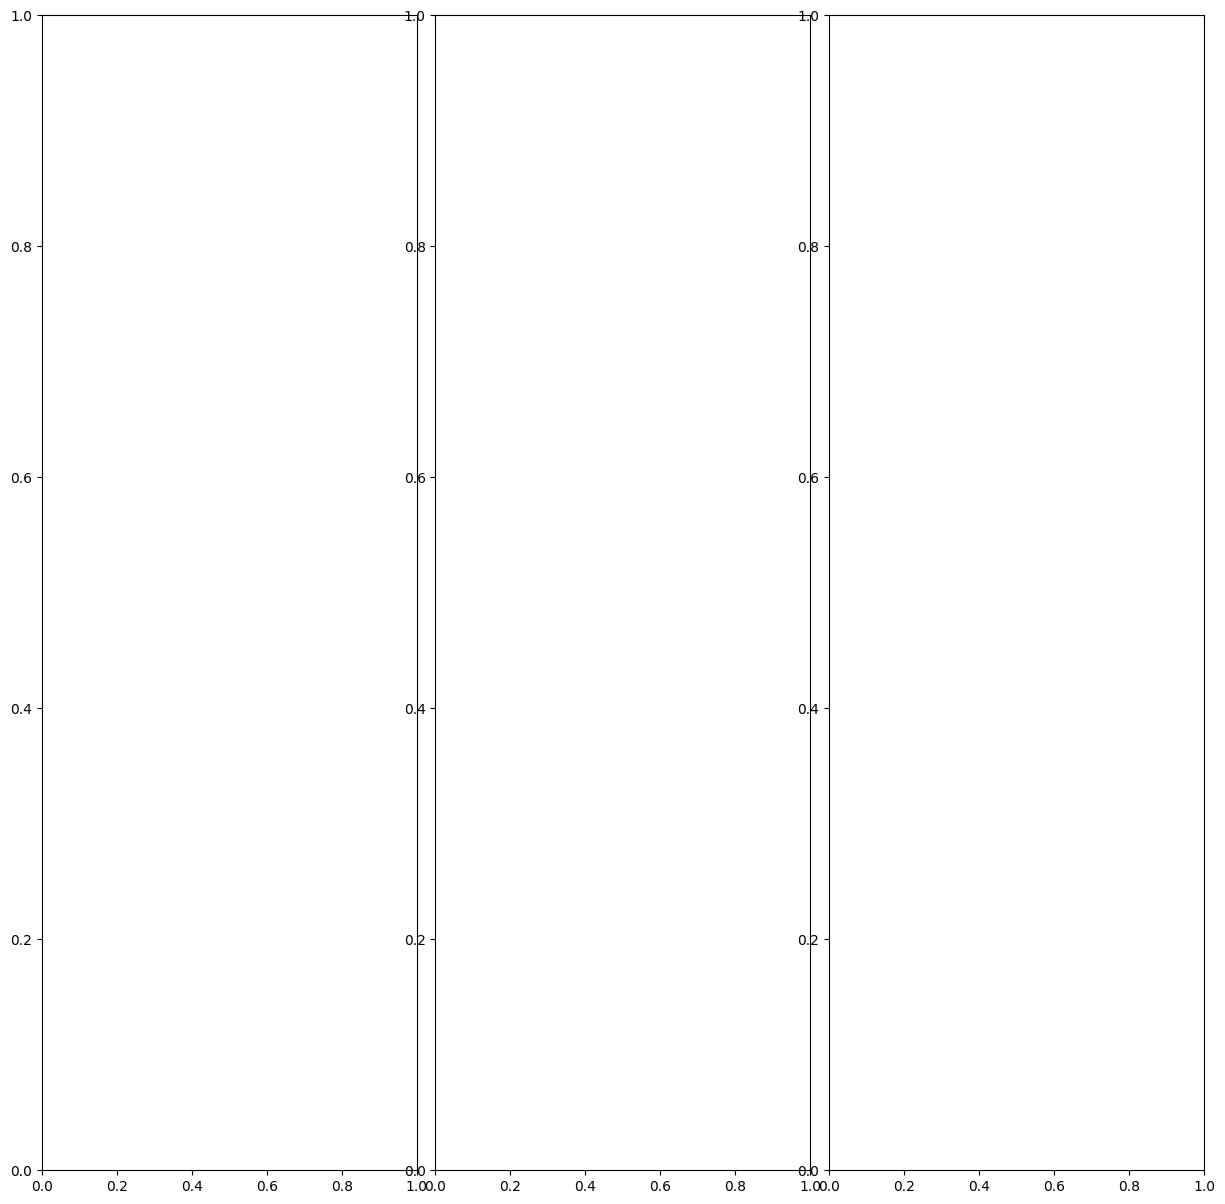

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
fig.subplots_adjust(wspace=0.05, hspace=0)

img, _, y_hat = predict_tiff(data_dir / "raster_data_planet_scope/planetscope_REQ_6794.tif", conf_path="conf/postprocess.yaml")
p_thresh = 0.45

#ax[0].imshow(tr_trunc(img[[4, 3, 1]]))
ax[1].imshow(y_hat[:, :, 0])
ax[2].imshow(y_hat[:, :, 0] > p_thresh)